In [8]:
import os

if not "src" in os.listdir():
    os.chdir("../../")
os.listdir()

['src',
 'requirements.txt',
 'tests',
 '.pytest_cache',
 '.idea',
 '.githooks',
 '.git',
 'notebooks',
 '.pre-commit-config.yaml',
 'old_code',
 'data',
 'README.md',
 '.gitignore',
 'pytest.ini']

In [9]:
import torch
from src.utils.data.pcm.mnist_cond_trans_dataset import ConditionalMNIST
from src.utils.config import load_config_from_path
from pathlib import Path
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [11]:
cmnist_train = ConditionalMNIST(
    cfg=load_config_from_path(
        file_path=Path("notebooks") / "experiments" / "config" / "pcm-mnist-0.yaml"
    )
)

In [12]:
def show_img(img: torch.Tensor, figsize=(2, 2)):
    img = transforms.ToPILImage()(img)
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()

In [18]:
cmnist_train[0].keys()

dict_keys(['img', 'condition_token_ids', 'condition_values'])

Condition tokens (0 - pad): tensor([2., 3., 0., 0.]) 
Condition values: tensor([1., 0., 0., 0.])


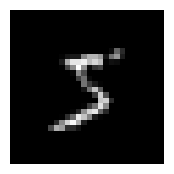

Condition tokens (0 - pad): tensor([1, 3, 3, 0]) 
Condition values: tensor([5., 1., 0., 0.])


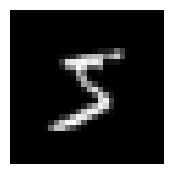

Condition tokens (0 - pad): tensor([1, 2, 3, 0]) 
Condition values: tensor([5.0000, 0.7830, 0.0000, 0.0000])


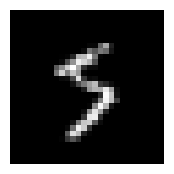

Condition tokens (0 - pad): tensor([1, 3, 0, 0]) 
Condition values: tensor([0.7165, 1.0000, 0.0000, 0.0000])


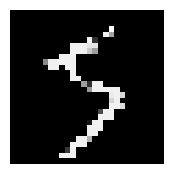

Condition tokens (0 - pad): tensor([1, 3, 0, 0]) 
Condition values: tensor([0.6816, 0.0000, 0.0000, 0.0000])


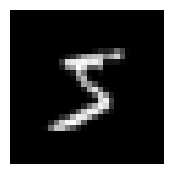

In [37]:
for _ in range(5):
    print(
        f'Condition tokens (0 - pad): {cmnist_train[0]["condition_token_ids"]} \nCondition values: {cmnist_train[0]["condition_values"]}'
    )
    show_img(img=cmnist_train[0]["img"][0])